In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.__version__)


2.9.1


In [2]:
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'dogs')))
dataset_train_sharks_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'sharks')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(
    os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(
    os.path.join(dataset_validation_dir, 'dogs')))
dataset_validation_sharks_len = len(os.listdir(
    os.path.join(dataset_validation_dir, 'sharks')))


In [3]:
print('Training Cats: %s' % dataset_train_cats_len)
print('Training Dogs: %s' % dataset_train_dogs_len)
print('Training Sharks: %s' % dataset_train_sharks_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)
print('Validation Sharks: %s' % dataset_validation_sharks_len)

Training Cats: 1000
Training Dogs: 1000
Training Sharks: 965
Validation Cats: 500
Validation Dogs: 500
Validation Sharks: 467


In [4]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel, )


batch_size = 32
epochs = 20
learning_rate = 0.001

class_names = ['cat', 'dog', 'shark']

In [5]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)

Found 2965 files belonging to 3 classes.


In [6]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 1467 files belonging to 3 classes.


In [7]:
dataset_validation_cardinality = tf.data.experimental.cardinality(
    dataset_validation)
dataset_validation_bathes = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_bathes)
dataset_validation = dataset_validation.skip(dataset_validation_bathes)

In [8]:
print('Validation Dataset Cardinality: %d' %
      tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' %
      tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 37
Test Dataset Cardinality: 9


In [9]:
# resize the images to a common size
def preprocess_image(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label
  
dataset_train = dataset_train.map(preprocess_image)
dataset_test = dataset_test.map(preprocess_image)
dataset_validation = dataset_validation.map(preprocess_image)



In [10]:
 
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

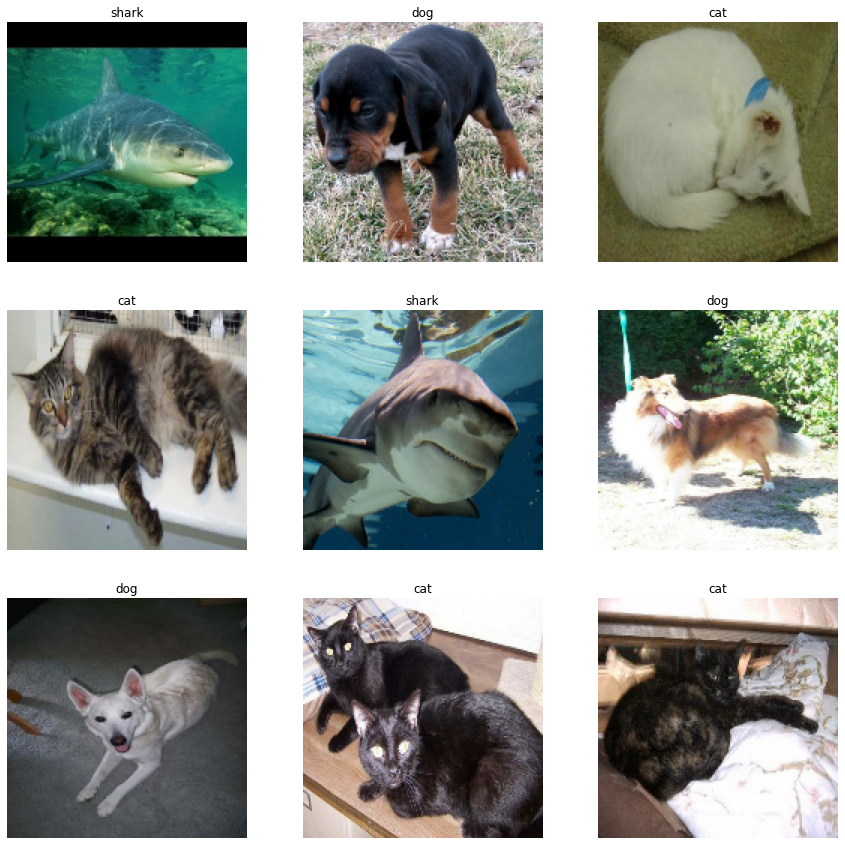

In [11]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

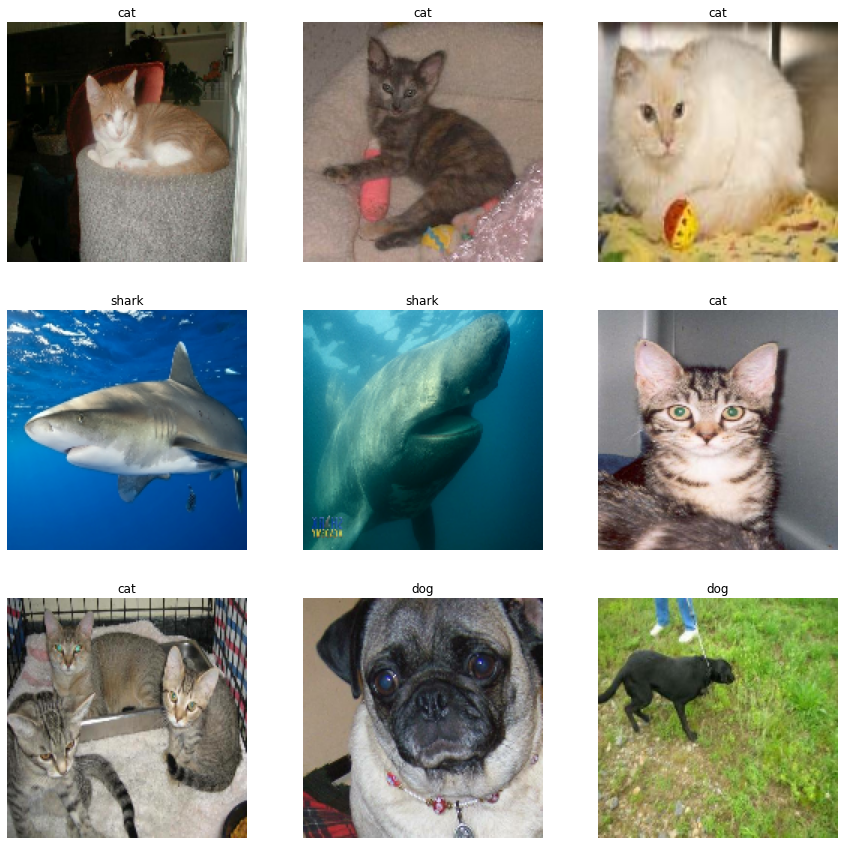

In [12]:
plot_dataset(dataset_test)

<Figure size 432x288 with 0 Axes>

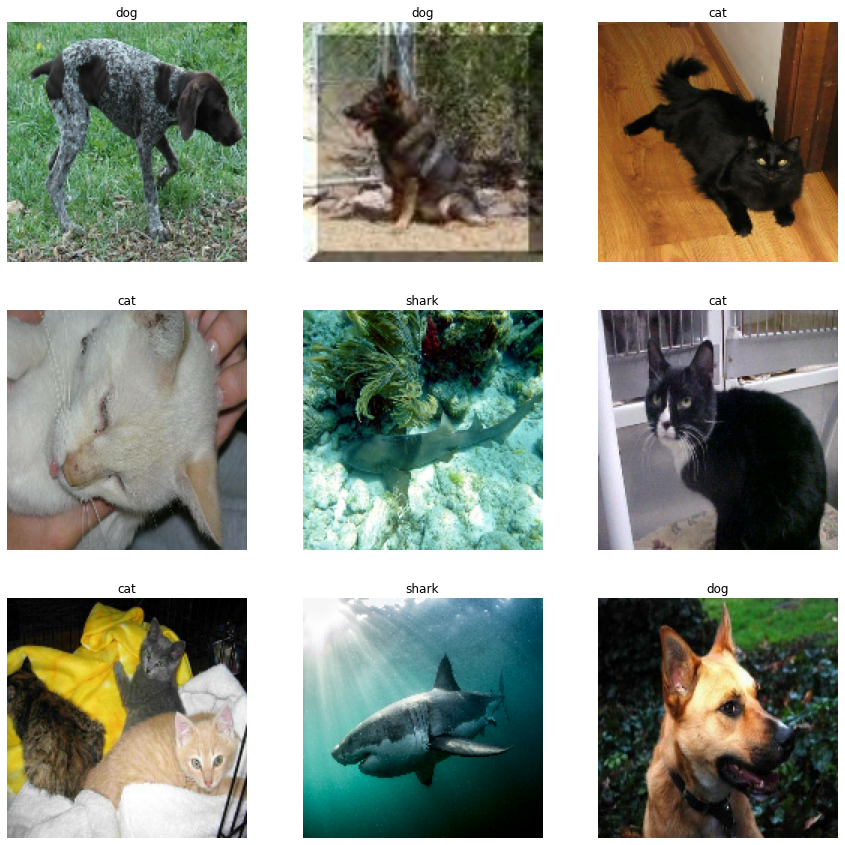

In [13]:
plot_dataset(dataset_train)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [15]:
def plot_dataset_data_augmentation(dataset):
  plt.gcf().clear()
  plt.figure(figsize=(15, 15))
  
  for features, _ in dataset.take(1):
    feature = features[0]
    
    for i in range(9):
      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))
      
      plt.subplot(3, 3, i + 1)
      plt.axis('off')
      
      plt.imshow(feature_data_augmentation[0]  / image_color_channel_size)

<Figure size 432x288 with 0 Axes>

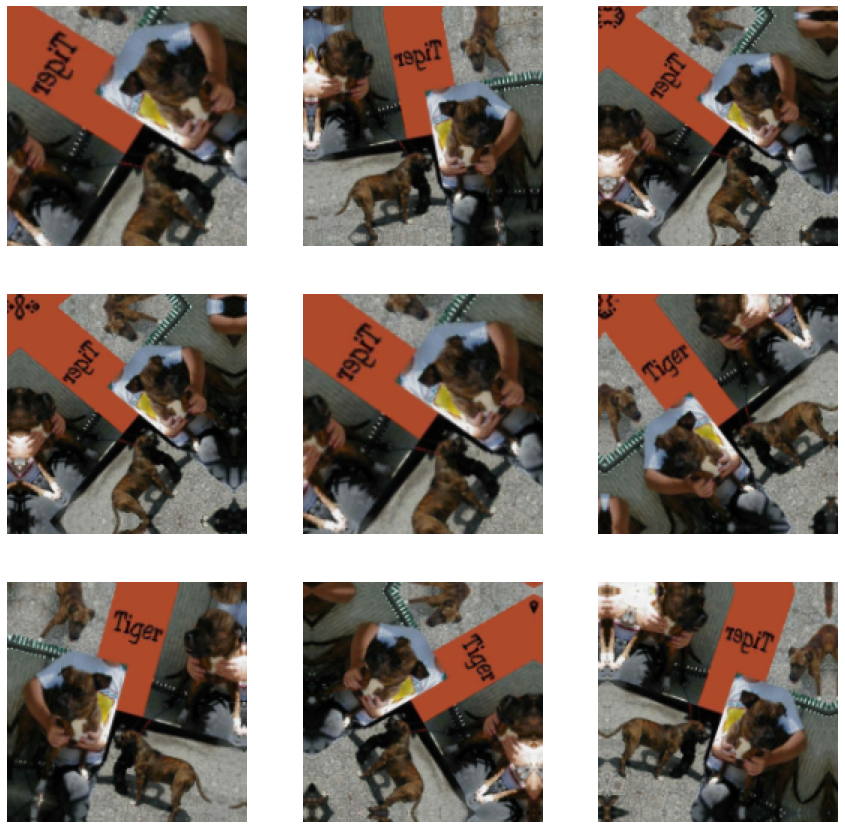

In [16]:
plot_dataset_data_augmentation(dataset_train)

In [17]:
model_transfer_learning = tf.keras.applications.MobileNetV2(
  input_shape=image_shape,
  include_top=False,
  weights = 'imagenet'
)

model_transfer_learning.trainable = False
model_transfer_learning.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / image_color_channel_size,
        input_shape=image_shape
    ),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / (image_color_channel_size/2),
        offset = -1,
        input_shape=image_shape
    ),
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)             

In [21]:
history = model.fit(
  dataset_train,
  validation_data=dataset_validation,
  epochs=epochs,
)

Epoch 1/20
93/93 [==============================] - 30s 256ms/step - loss: 0.2088 - accuracy: 0.9302 - val_loss: 0.0438 - val_accuracy: 0.9839
Epoch 2/20
93/93 [==============================] - 14s 139ms/step - loss: 0.1435 - accuracy: 0.9437 - val_loss: 0.0328 - val_accuracy: 0.9873
Epoch 3/20
93/93 [==============================] - 13s 136ms/step - loss: 0.1028 - accuracy: 0.9619 - val_loss: 0.0296 - val_accuracy: 0.9907
Epoch 4/20
93/93 [==============================] - 14s 140ms/step - loss: 0.0945 - accuracy: 0.9599 - val_loss: 0.0286 - val_accuracy: 0.9907
Epoch 5/20
93/93 [==============================] - 13s 136ms/step - loss: 0.0911 - accuracy: 0.9632 - val_loss: 0.0268 - val_accuracy: 0.9898
Epoch 6/20
93/93 [==============================] - 13s 135ms/step - loss: 0.0855 - accuracy: 0.9663 - val_loss: 0.0321 - val_accuracy: 0.9873
Epoch 7/20
93/93 [==============================] - 15s 151ms/step - loss: 0.0904 - accuracy: 0.9680 - val_loss: 0.0331 - val_accuracy: 0.9890

In [22]:
def plot_model():
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs_range = range(epochs)
  
  plt.gcf().clear()
  plt.figure(figsize=(15,8))
  
  plt.subplot(1,2,1)
  plt.title('Training and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(1,2,2)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower right')
  
  plt.show()

<Figure size 432x288 with 0 Axes>

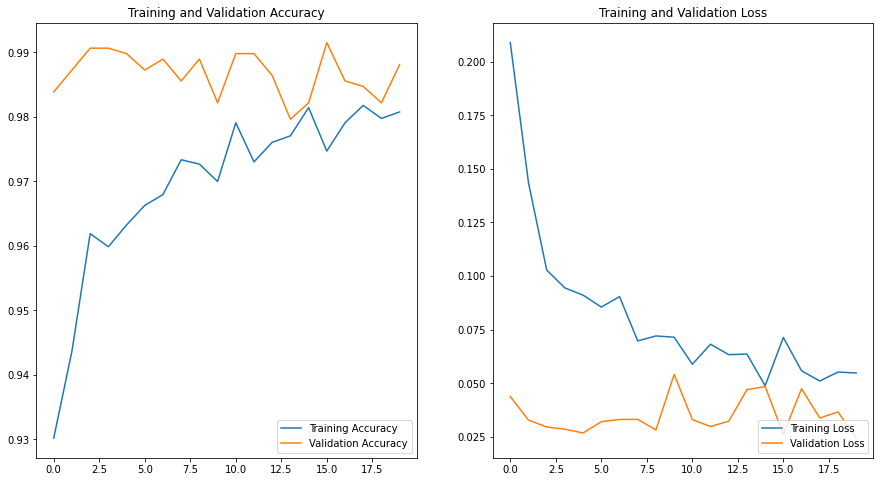

In [23]:
plot_model()

In [48]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if(predicted_label == true_label):
        color = 'white'
    else:
        color = 'red'

    plt.title("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100*np.max(predictions_array),
        class_names[true_label]),
        color=color)


def plot_results(predictions, labels, images):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    # len of test_images
    len = predictions.shape[0]

    # random 25 different images
    arrayindex = random.sample(range(len), 25)

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plot_image(arrayindex[i], predictions[arrayindex[i]], labels, images)

In [49]:

features, labels = dataset_test.as_numpy_iterator().next()
predictions = model.predict(features)


1/1 [==============================] - 0s 29ms/step


<Figure size 432x288 with 0 Axes>

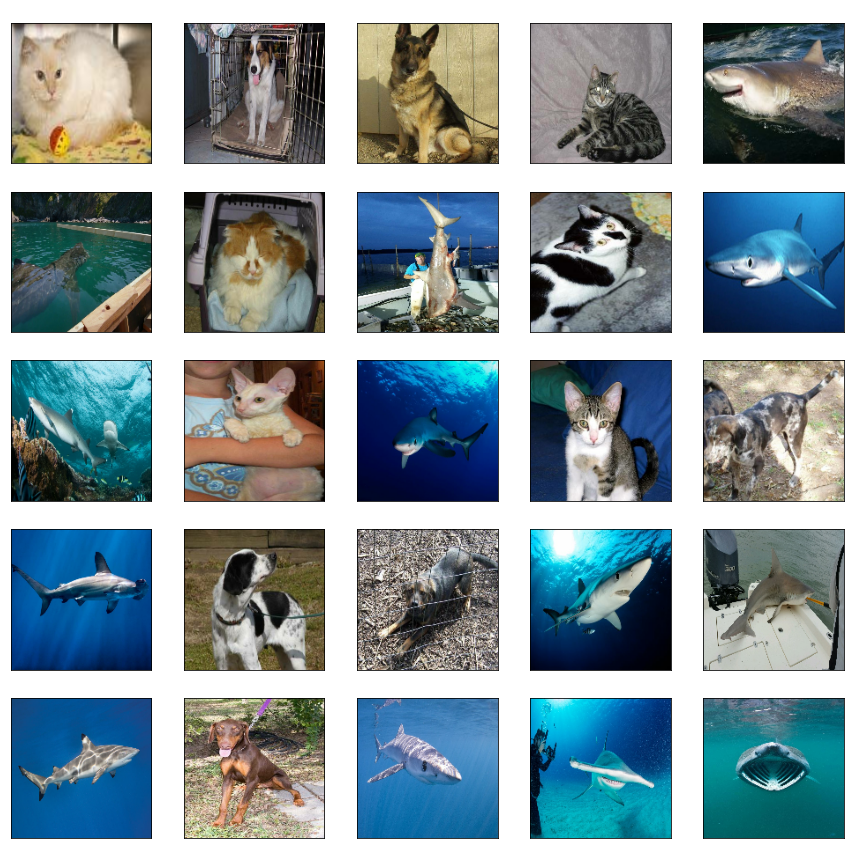

In [50]:
plot_results(predictions, labels, features)

In [27]:
model.save('models/cats_and_dogs_model.h5')

In [28]:
model = tf.keras.models.load_model('models/cats_and_dogs_model.h5')